This is main supervised training code for both AEs/VAEs features. Main operators are main_multi_train_error_bar() and main_multi_train_error_bar_dual()

main_multi_train_error_bar() trains MLP with several different feature inputs. The hyperparameters are set by hand, including epoch, batch size, n_runs, LR. The All models are plotted in the Same graph,with adjustable legends. The actual by predicted and actual by residual is based on the last run of the last epoch of the first csv features entry.

main_multi_train_error_bar_dual() trains MLP with several different feature inputs grouped into two groups. Each group is plotted into an integrated graph, and legend is shared between both graphs.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'  # Add this BEFORE importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import csv
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import GroupKFold
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [2]:
def load_data(csv_file, target_index=1):
    X = []
    Y = []

    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header

        for row in reader:
            try:
                y = float(row[target_index])
                if y == 0:
                    continue  # Skip if label is 0

                x_values = [float(x) for x in row[6:]]
                Y.append([y])  # Keep as 2D array for PyTorch
                X.append(x_values)
            except ValueError:
                continue  # Skip rows with invalid numbers
    #print(Y)

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)


In [3]:
import torch.nn as nn

class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

In [4]:
def mae_loss(y_pred, y_true):
    return F.l1_loss(y_pred.view(-1), y_true.view(-1))


def mse_loss(y_pred, y_true):
    return F.mse_loss(y_pred.view(-1), y_true.view(-1))

def mape_loss(y_pred, y_true):
    epsilon = 1e-8
    return torch.mean(torch.abs((y_true.view(-1) - y_pred.view(-1)) / (y_true.view(-1) + epsilon))) * 100

def r2_loss(y_pred, y_true):
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    y_mean = torch.mean(y_true)
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    return 1 - ss_res / (ss_tot + 1e-8)



In [5]:
import numpy as np
import torch
from torch.utils.data import Subset

def group_train_val_split(labels, test_size=0.2, random_seed=41):
    """
    Args:
        labels: numpy array or list of group labels (e.g. y labels)
        test_size: float fraction for val set size
    Returns:
        train_indices, val_indices: indices of samples in train and val sets
    """
    np.random.seed(random_seed)
    labels = np.array(labels)
    unique_groups = np.unique(labels)
    np.random.shuffle(unique_groups)
    
    n_val = int(len(unique_groups) * test_size)
    val_groups = unique_groups[:n_val]
    train_groups = unique_groups[n_val:]
    
    train_indices = [i for i, lbl in enumerate(labels) if lbl in train_groups]
    val_indices = [i for i, lbl in enumerate(labels) if lbl in val_groups]
    
    print(f"Total groups: {len(unique_groups)}")
    print(f"Train groups: {len(train_groups)}, Val groups: {len(val_groups)}")
    #print(val_indices)
    return train_indices, val_indices


In [6]:
def normalize_labels(Y, train_indices, val_indices):
    Y = np.array(Y)
    Y_train = Y[train_indices]
    Y_val = Y[val_indices]

    mean = Y_train.mean()
    std = Y_train.std()
    std = std if std != 0 else 1e-8  # avoid divide-by-zero

    Y_train_norm = (Y_train - mean) / std
    Y_val_norm = (Y_val - mean) / std

    #print(Y_val_norm)
    return Y_train_norm, Y_val_norm, mean, std


In [7]:
def train_model(X, Y, labels=None, num_epochs=100, batch_size=24, learning_rate=5e-5):
    """
    Train a FeedforwardNN model with group-based train/val split.
    If any entry in X or Y is NaN, that row is ignored.
    Returns:
        model,
        y_train, y_pred_train,
        y_val, y_pred_val,
        val_loss_norm, val_loss_denorm,
        mean, std,
        val_r2
    """
    import torch
    from torch.utils.data import DataLoader, TensorDataset, Subset
    import numpy as np
    from sklearn.metrics import r2_score

    # Ensure numpy arrays
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32).reshape(-1, 1)

    # --- Remove NaN rows ---
    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(Y).ravel()
    X = X[mask]
    Y = Y[mask]
    if labels is not None:
        labels = np.array(labels)[mask]

    # Normalize target
    mean = Y.mean()
    std = Y.std()
    Y_norm = (Y - mean) / std

    # Build dataset
    dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y_norm))

    # Group-based split
    if labels is None:
        raise ValueError("labels must be provided for group_train_val_split")
    train_indices, val_indices = group_train_val_split(labels, test_size=0.2, random_seed=42)

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    input_dim = X.shape[1]
    model = FeedforwardNN(input_dim)

    # Loss and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    val_loss_norm = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # --- Metrics ---
        model.eval()
        with torch.no_grad():
            # Train metrics
            train_preds, train_targets = [], []
            for xb, yb in train_loader:
                preds = model(xb)
                train_preds.append(preds.numpy())
                train_targets.append(yb.numpy())
            train_preds = np.vstack(train_preds)
            train_targets = np.vstack(train_targets)
            mse_train_norm = np.mean((train_preds - train_targets) ** 2)
            mse_train_denorm = mse_train_norm * (std ** 2)
            r2_train = r2_score(train_targets * std + mean,
                                train_preds * std + mean)

            # Val metrics
            val_preds, val_targets = [], []
            for xb, yb in val_loader:
                preds = model(xb)
                val_preds.append(preds.numpy())
                val_targets.append(yb.numpy())
            val_preds = np.vstack(val_preds)
            val_targets = np.vstack(val_targets)
            mse_val_norm = np.mean((val_preds - val_targets) ** 2)
            mse_val_denorm = mse_val_norm * (std ** 2)
            r2_val = r2_score(val_targets * std + mean,
                              val_preds * std + mean)

            val_loss_norm.append(mse_val_norm)

        # Print metrics
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train MSE (norm): {mse_train_norm:.6f} | "
              f"Train MSE (denorm): {mse_train_denorm:.6f} | "
              f"Train R²: {r2_train:.4f} || "
              f"Val MSE (norm): {mse_val_norm:.6f} | "
              f"Val MSE (denorm): {mse_val_denorm:.6f} | "
              f"Val R²: {r2_val:.4f}")

    # Final predictions for return values
    model.eval()
    with torch.no_grad():
        X_train = torch.from_numpy(X[train_indices]).numpy()
        y_train = torch.from_numpy(Y_norm[train_indices]).numpy()
        y_pred_train = model(torch.from_numpy(X_train)).numpy()

        X_val = torch.from_numpy(X[val_indices]).numpy()
        y_val = torch.from_numpy(Y_norm[val_indices]).numpy()
        y_pred_val = model(torch.from_numpy(X_val)).numpy()

    val_loss_denorm = [(l * (std ** 2)) for l in val_loss_norm]

    # Final validation R² in denormalized space
    y_val_denorm = y_val * std + mean
    y_pred_val_denorm = y_pred_val * std + mean
    val_r2 = r2_score(y_val_denorm, y_pred_val_denorm)

    return (
        model,
        y_train, y_pred_train,
        y_val, y_pred_val,
        np.array(val_loss_norm),
        np.array(val_loss_denorm),
        mean, std,
        val_r2
    )


[1] AE 8 dim (AE_8_finetuned_partmag.csv)...
   Run 1/2
Total groups: 146
Train groups: 117, Val groups: 29
Epoch   1/20 | Train MSE (norm): 1.100417 | Train MSE (denorm): 24.623008 | Train R²: -0.0084 || Val MSE (norm): 0.684796 | Val MSE (denorm): 15.323043 | Val R²: -0.0174
Epoch   2/20 | Train MSE (norm): 1.053923 | Train MSE (denorm): 23.582652 | Train R²: 0.0342 || Val MSE (norm): 0.679119 | Val MSE (denorm): 15.196021 | Val R²: -0.0089
Epoch   3/20 | Train MSE (norm): 1.021897 | Train MSE (denorm): 22.866043 | Train R²: 0.0635 || Val MSE (norm): 0.685821 | Val MSE (denorm): 15.345982 | Val R²: -0.0189
Epoch   4/20 | Train MSE (norm): 1.004670 | Train MSE (denorm): 22.480553 | Train R²: 0.0793 || Val MSE (norm): 0.682418 | Val MSE (denorm): 15.269837 | Val R²: -0.0138
Epoch   5/20 | Train MSE (norm): 0.985144 | Train MSE (denorm): 22.043655 | Train R²: 0.0972 || Val MSE (norm): 0.678673 | Val MSE (denorm): 15.186040 | Val R²: -0.0083
Epoch   6/20 | Train MSE (norm): 0.971323 | Tr

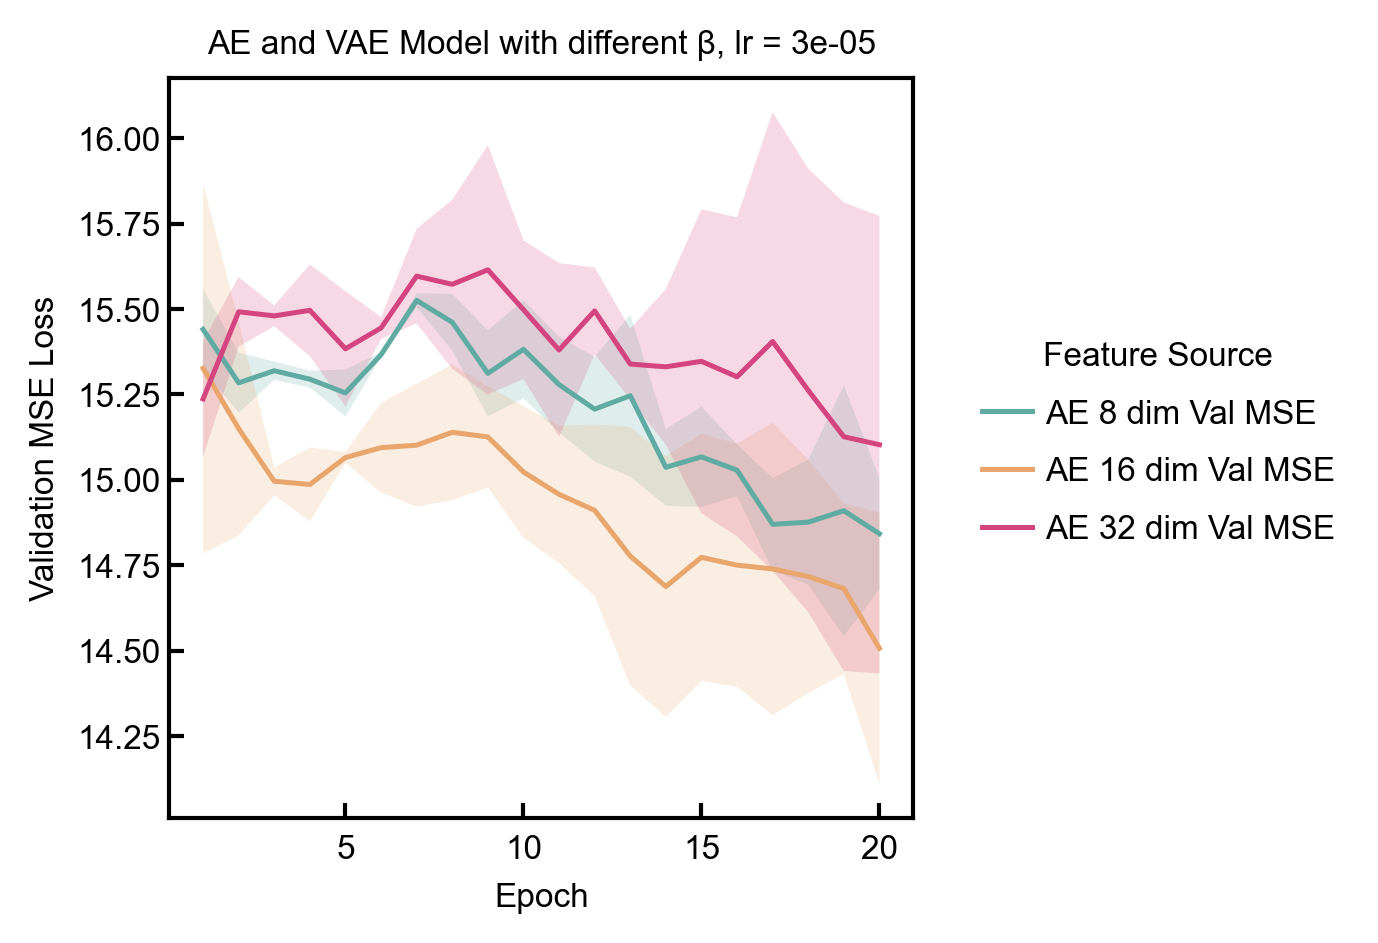

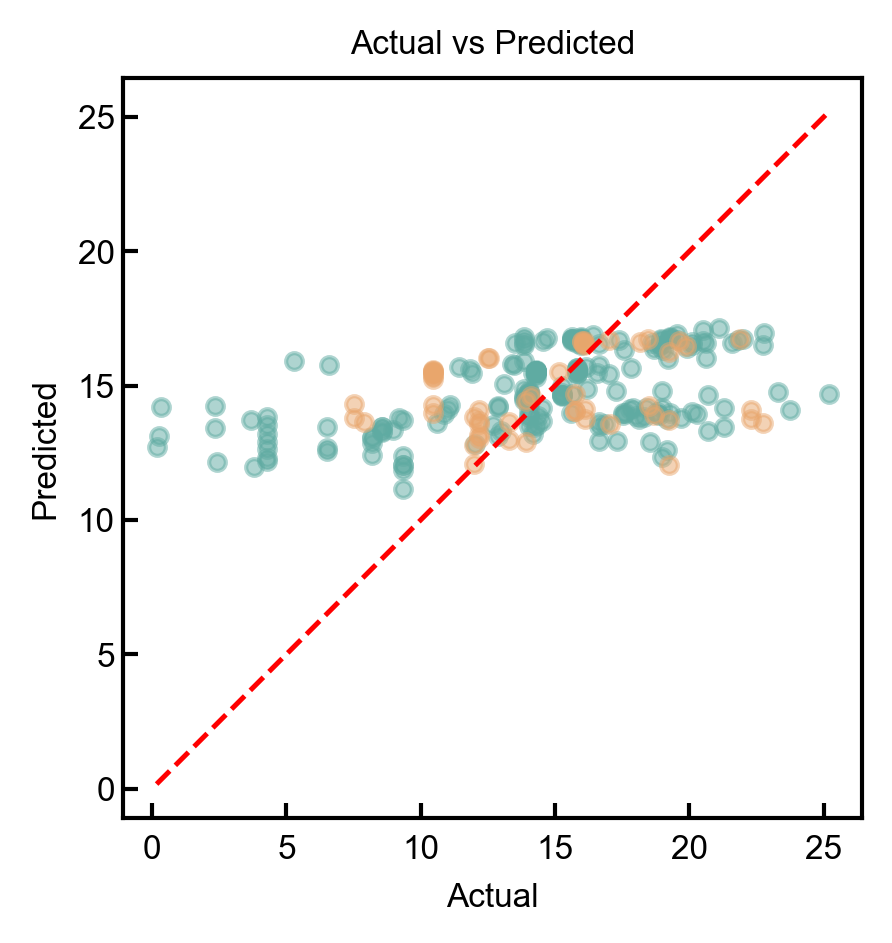

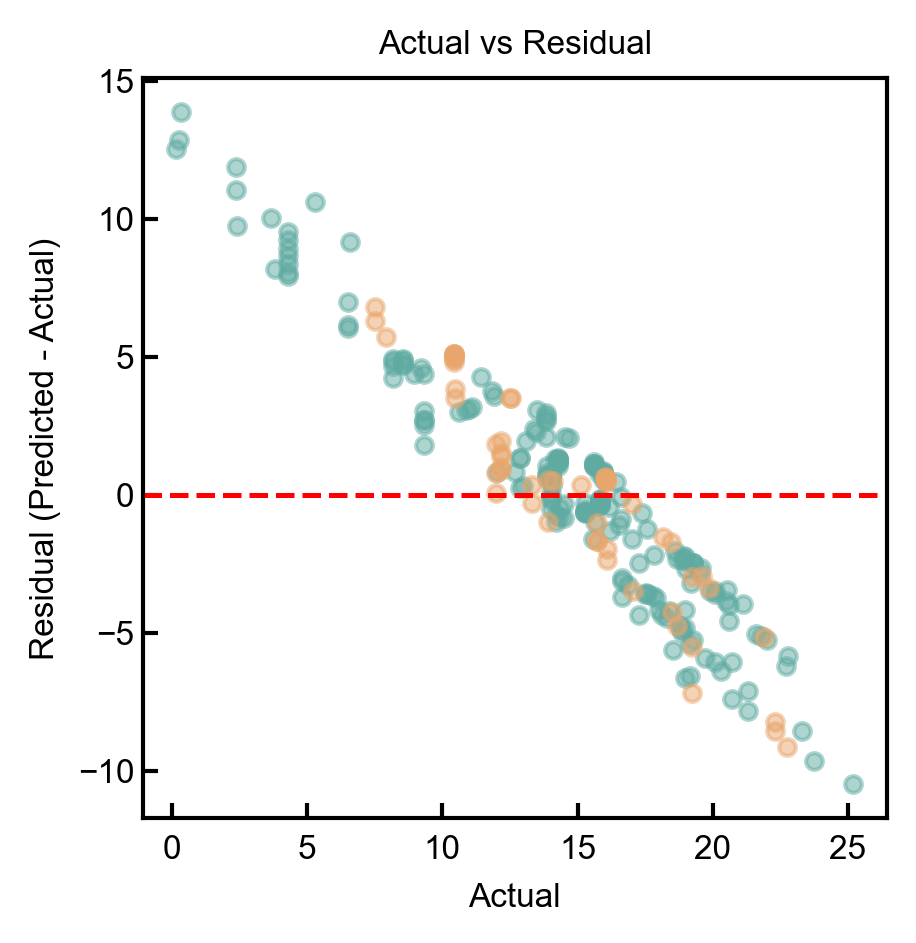

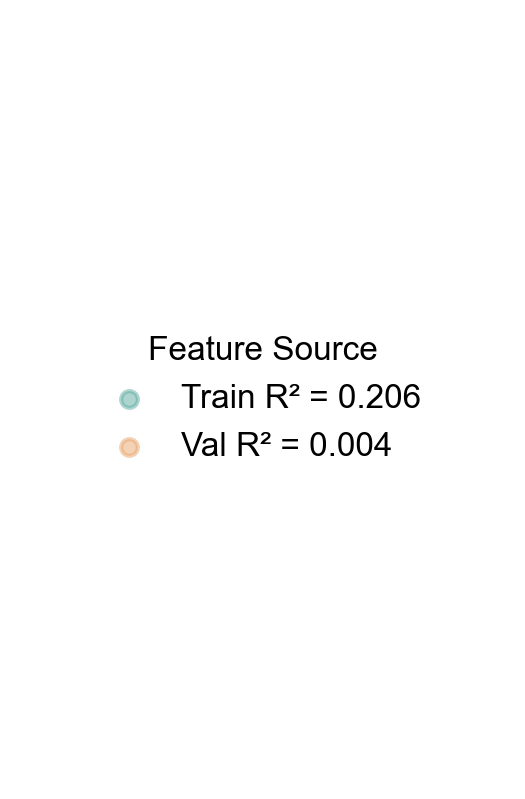

In [ ]:
def main_multi_train_error_bar(csv_files, labels=None,  n_runs=3, num_epochs=20, batch_size=24,
                               learning_rate=3e-5):
    """
    Train and compare multiple models on different CSV files, each trained n_runs times.
    Plots mean ± std of validation loss over epochs.
    On scatterplots, shows R² from the last run and average R² across runs.

    Parameters
    ----------
    csv_files : list of str
        List of CSV file paths. Can be 1 to 10 files.
    labels : list of str, optional
        List of labels corresponding to each file.
    n_runs : int
        How many times to re-run training for each CSV file.
    """

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score

    n_files = len(csv_files)
    if n_files < 1 or n_files > 10:
        raise ValueError("Please provide between 1 and 10 CSV files.")

    if labels is None:
        labels = [f"Model {i+1}" for i in range(n_files)]

    all_val_loss_mean = []
    all_val_loss_std = []

    # For scatterplots we’ll use the last run’s data for y values,
    # but also store average R² across runs
    scatter_y_train = []
    scatter_y_pred_train = []
    scatter_y_val = []
    scatter_y_pred_val = []
    all_r2_last = []
    all_r2_avg = []

    for i, csv_file in enumerate(csv_files):
        label = labels[i]
        print(f"[{i+1}] {label} ({os.path.basename(csv_file)})...")

        X, Y = load_data(csv_file, target_index=4)

        val_losses_runs = []
        r2_runs = []
        r2_train_runs = []
        last_run_data = None

        for run in range(n_runs):
            print(f"   Run {run+1}/{n_runs}")
            _, y_train, y_pred_train, y_val, y_pred_val, val_loss_norm, val_loss_denorm, mean, std, val_r2 = train_model(
                X, Y, labels=Y, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate
            )

            # Denormalize
            y_train = y_train * std + mean
            y_pred_train = y_pred_train * std + mean
            y_val = y_val * std + mean
            y_pred_val = y_pred_val * std + mean

            # Save data for the *last* run
            if run == n_runs - 1:
                last_run_data = (y_train, y_pred_train, y_val, y_pred_val)

            val_losses_runs.append(val_loss_denorm)
            r2_runs.append(val_r2)

            train_r2 = r2_score(y_train, y_pred_train)
            r2_train_runs.append(train_r2)

        # Stack losses
        val_losses_runs = np.vstack(val_losses_runs)
        mean_loss = val_losses_runs.mean(axis=0)
        std_loss = val_losses_runs.std(axis=0)
        all_val_loss_mean.append(mean_loss)
        all_val_loss_std.append(std_loss)

        # R² statistics
        r2_runs = np.array(r2_runs)
        r2_train_runs = np.array(r2_train_runs)
        r2_avg = r2_runs.mean()
        r2_last = r2_runs[-1]
        r2_train_last = r2_train_runs[-1]
        all_r2_last.append((r2_last, r2_train_last))
        all_r2_avg.append(r2_avg)

        # Scatter data from last run
        y_train, y_pred_train, y_val, y_pred_val = last_run_data
        scatter_y_train.append(y_train)
        scatter_y_pred_train.append(y_pred_train)
        scatter_y_val.append(y_val)
        scatter_y_pred_val.append(y_pred_val)

    # === Plot 1: Validation Loss Curve ===
    plt.style.use("style.mplstyle")  # Apply style before figure creation

    epochs = np.arange(1, num_epochs + 1)
    fig, ax = plt.subplots(figsize=(3.2, 3.2), dpi=plt.rcParams["figure.dpi"])  # Explicit size

    for i in range(n_files):
        mean_loss = all_val_loss_mean[i]
        std_loss = all_val_loss_std[i]
        ax.plot(epochs, mean_loss, label=f'{labels[i]} Val MSE')
        ax.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation MSE Loss")
    ax.set_title(f"AE and VAE Model with different β, lr = {learning_rate}")

    handles, labels_legend = ax.get_legend_handles_labels()
    fig.legend(
        handles, labels_legend,
        loc='center left',
        bbox_to_anchor=(0.94, 0.5),
        ncol=1,
        fontsize=8,
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.4,
        borderaxespad=0.5,
        borderpad=0.4,
        labelspacing=0.8,
        title="Feature Source",
        title_fontsize=8
    )

    plt.show()

    # Assuming these variables exist from your code:
    # scatter_y_train, scatter_y_pred_train, scatter_y_val, scatter_y_pred_val, all_r2_last

    val_r2, train_r2 = all_r2_last[0]

    # Flatten arrays
    # Flatten arrays
    y_train = np.array(scatter_y_train[0]).flatten()
    y_pred_train = np.array(scatter_y_pred_train[0]).flatten()
    y_val = np.array(scatter_y_val[0]).flatten()
    y_pred_val = np.array(scatter_y_pred_val[0]).flatten()

    # Residuals as predicted - actual
    resid_train = y_pred_train - y_train
    resid_val = y_pred_val - y_val


    # === Figure 1: Actual vs Predicted ===
    fig1, ax1 = plt.subplots(figsize=(3.2, 3.2), dpi=plt.rcParams["figure.dpi"])
    ax1.scatter(y_train, y_pred_train, alpha=0.5, label=f'Train R² = {train_r2:.3f}')
    ax1.scatter(y_val, y_pred_val, alpha=0.5, label=f'Val R² = {val_r2:.3f}')
    min_val = min(y_train.min(), y_val.min())
    max_val = max(y_train.max(), y_val.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--')
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_xlabel("Actual")
    ax1.set_ylabel("Predicted")
    ax1.set_title("Actual vs Predicted")

    # === Figure 2: Residuals ===
    fig2, ax2 = plt.subplots(figsize=(3.2, 3.2), dpi=plt.rcParams["figure.dpi"])
    ax2.scatter(y_train, resid_train, alpha=0.5)
    ax2.scatter(y_val, resid_val, alpha=0.5)
    ax2.axhline(0, color='r', linestyle='--')
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Residual (Predicted - Actual)")
    ax2.set_title("Actual vs Residual")

    # === Figure 3: Legend only ===
    fig_legend = plt.figure(figsize=(2, 3.2), dpi=plt.rcParams["figure.dpi"])
    fig_legend.patch.set_alpha(0)  # optional: transparent background

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Combine legend handles and labels (avoid duplicates if you want)
    handles = handles1 + handles2
    labels = labels1 + labels2

    fig_legend.legend(
        handles, labels,
        loc='center',
        fontsize=8,
        frameon=False,
        title="Feature Source",
        title_fontsize=8
    )

    plt.axis('off')  # Hide axes on legend figure

    plt.show()


main_multi_train_error_bar(
    [
    r"Extracted Features\part mag\AE_8_finetuned_partmag.csv",
    r"Extracted Features\part mag\AE_16_finetuned_partmag.csv",
    r"Extracted Features\part mag\AE_32_finetuned_partmag.csv",
    ],
    labels=['AE 8 dim', 'AE 16 dim', 'AE 32 dim'],
    n_runs=2
    )   




[1] No Magpie (AE_32_finetuned_nomag.csv)...
   Run 1/5 | lr=5e-06
Total groups: 146
Train groups: 117, Val groups: 29
Epoch   1/10 | Train MSE (norm): 1.101159 | Train MSE (denorm): 24.639599 | Train R²: -0.0091 || Val MSE (norm): 0.685603 | Val MSE (denorm): 15.341103 | Val R²: -0.0186
Epoch   2/10 | Train MSE (norm): 1.094624 | Train MSE (denorm): 24.493370 | Train R²: -0.0031 || Val MSE (norm): 0.681551 | Val MSE (denorm): 15.250424 | Val R²: -0.0125
Epoch   3/10 | Train MSE (norm): 1.092039 | Train MSE (denorm): 24.435532 | Train R²: -0.0007 || Val MSE (norm): 0.679878 | Val MSE (denorm): 15.212997 | Val R²: -0.0101
Epoch   4/10 | Train MSE (norm): 1.086716 | Train MSE (denorm): 24.316421 | Train R²: 0.0041 || Val MSE (norm): 0.683480 | Val MSE (denorm): 15.293595 | Val R²: -0.0154
Epoch   5/10 | Train MSE (norm): 1.082390 | Train MSE (denorm): 24.219630 | Train R²: 0.0081 || Val MSE (norm): 0.683078 | Val MSE (denorm): 15.284595 | Val R²: -0.0148
Epoch   6/10 | Train MSE (norm): 

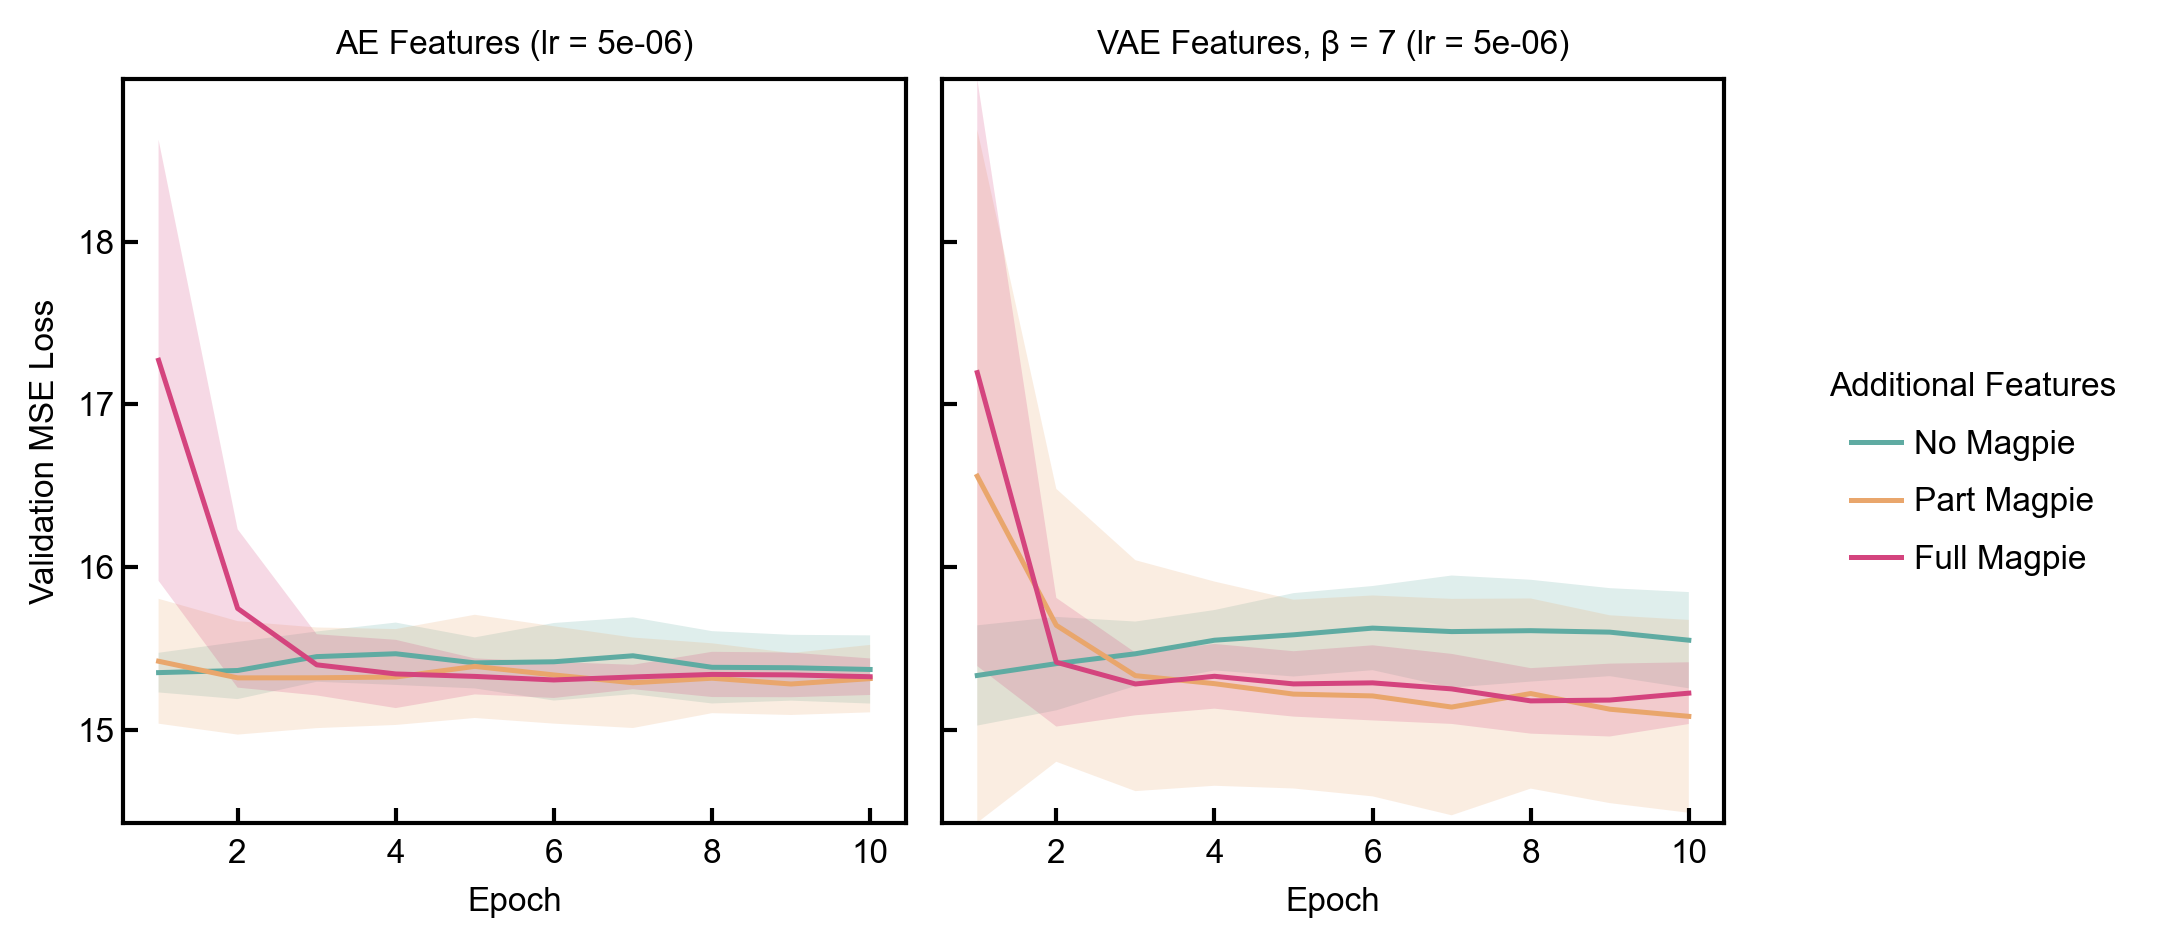

In [21]:
def main_multi_train_error_bar_dual(
    csv_files_list1, csv_files_list2,
    labels_list=None , n_runs=3,
    num_epochs=10, batch_size=24,
    learning_rate1=5e-6, learning_rate2=5e-6,
):
    """
    Compare two sets of CSV files (two experiments), plotting mean ± std validation loss curves
    side-by-side with unified y-axis and joint legend.
    Both plots share the same labels and colors for matching models.
    """

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from itertools import cycle

    if labels_list is None:
        if len(csv_files_list1) != len(csv_files_list2):
            raise ValueError("When labels_list is None, both CSV lists must have the same length.")
        labels_list = [f"Model {i+1}" for i in range(len(csv_files_list1))]


    def process_csv_list(csv_files, lr):
        all_val_loss_mean = []
        all_val_loss_std = []
        for i, csv_file in enumerate(csv_files):
            label = labels_list[i]
            print(f"[{i+1}] {label} ({os.path.basename(csv_file)})...")

            X, Y = load_data(csv_file, target_index=4)

            val_losses_runs = []
            for run in range(n_runs):
                print(f"   Run {run+1}/{n_runs} | lr={lr}")
                _, y_train, y_pred_train, y_val, y_pred_val, val_loss_norm, val_loss_denorm, mean, std, val_r2 = train_model(
                    X, Y, labels=Y, num_epochs=num_epochs, batch_size=batch_size, learning_rate=lr
                )
                val_losses_runs.append(val_loss_denorm)

            val_losses_runs = np.vstack(val_losses_runs)
            mean_loss = val_losses_runs.mean(axis=0)
            std_loss = val_losses_runs.std(axis=0)

            all_val_loss_mean.append(mean_loss)
            all_val_loss_std.append(std_loss)

        return all_val_loss_mean, all_val_loss_std

    # Process both sets
    mean1, std1 = process_csv_list(csv_files_list1, learning_rate1)
    mean2, std2 = process_csv_list(csv_files_list2, learning_rate2)

    # Find global y-axis range
    all_means = mean1 + mean2
    all_stds = std1 + std2
    y_min = min((m - s).min() for m, s in zip(all_means, all_stds))
    y_max = max((m + s).max() for m, s in zip(all_means, all_stds))

    epochs = np.arange(1, num_epochs + 1)

    plt.style.use("../style.mplstyle")
    fig, axes = plt.subplots(1, 2, figsize=(6.4, 3.2), sharey=True)

    same_length = (len(mean1) == len(mean2))

    if same_length:
        # === Case 1: Both lists have the same number of models ===
        for i, label in enumerate(labels_list):
            axes[0].plot(epochs, mean1[i], label=label)
            axes[0].fill_between(epochs, mean1[i]-std1[i], mean1[i]+std1[i], alpha=0.2)

            axes[1].plot(epochs, mean2[i], label=label)
            axes[1].fill_between(epochs, mean2[i]-std2[i], mean2[i]+std2[i], alpha=0.2)

    else:
        # === Case 2: Different lengths ===
        for i in range(len(mean1)):
            label = labels_list[i] if i < len(labels_list) else f"AE_{i}"
            axes[0].plot(epochs, mean1[i], label=label)
            axes[0].fill_between(epochs, mean1[i]-std1[i], mean1[i]+std1[i], alpha=0.2)

        for i in range(len(mean2)):
            label = labels_list[i] if i < len(labels_list) else f"VAE_{i}"
            axes[1].plot(epochs, mean2[i], label=label)
            axes[1].fill_between(epochs, mean2[i]-std2[i], mean2[i]+std2[i], alpha=0.2)

    # Titles, axis labels
    axes[0].set_title(f"AE Features (lr = {learning_rate1})")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Validation MSE Loss")
    axes[0].set_ylim(y_min, y_max)

    axes[1].set_title(f"VAE Features, β = 7 (lr = {learning_rate2})")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylim(y_min, y_max)

    # Legend (always use left plot's labels as master)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc='center left',
        bbox_to_anchor=(0.94, 0.5),
        ncol=1,
        fontsize=8,
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.4,
        borderaxespad=0.5,
        borderpad=0.4,
        labelspacing=0.8,
        title="Additional Features",
        title_fontsize=8
    )

    plt.tight_layout(rect=[0, 0, 0.92, 1])
    plt.show()


main_multi_train_error_bar_dual(
    csv_files_list1=[
    r"Extracted Features\no mag\AE_32_finetuned_nomag.csv", 
    r"Extracted Features\part mag\AE_32_finetuned_partmag.csv", 
    r"Extracted Features\full mag\AE_32_finetuned.csv", 

    ],
    csv_files_list2=[
    r"Extracted Features\no mag\VAE_32_beta7_finetuned_nomag.csv",
    r"Extracted Features\part mag\VAE_32_beta7_finetuned_partmag.csv",
    r"Extracted Features\full mag\VAE_32_beta7_finetuned.csv",


    ],
    labels_list=[ "No Magpie", "Part Magpie", "Full Magpie"],
    n_runs = 5
)
